In [9]:
import os
os._exit(00)

: 

#### **1.1 library import**

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
import mglearn
import seaborn as sns
import scipy as sp
import sklearn

print(f"pyrhon version{sys.version}")
print(f"Numpy version: {np.__version__}") # 2.2.2
print(f"Pandas version: {np.__version__}") # 2.2.2
print(f"matplotlib version: {mpl.__version__}") # 3.10.0
print(f"scipy version: {sp.__version__}") # 1.15.1
print(f"mglearn version: {mglearn.__version__}") # 0.1.9
print(f"seaborn version: {sns.__version__}") # 0.1.9
print( f"torch version: {torch.__version__}") # 2.6.0+cu124
device = torch.cuda.is_available()
print( f"CUDA available: { device }" )
# 폰트 이름 가져오기
font_path = 'C:\WINDOWS\FONTS\GULIM.TTC'
font_name = mpl.font_manager.FontProperties(fname=font_path).get_name()

# 폰트 설정
plt.rc('font', family=font_name)

pyrhon version3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]
Numpy version: 2.2.2
Pandas version: 2.2.2
matplotlib version: 3.10.0
scipy version: 1.15.1
mglearn version: 0.1.9
seaborn version: 0.13.2
torch version: 2.6.0+cu124
CUDA available: True


#### **1.2 gan model**

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Latent(nn.Module):
    def __init__(self, latent_dim, img_size):
        super(Latent, self).__init__()
        self.latent = nn.Sequential(
            nn.Linear(latent_dim, (img_size**2)//2, bias=False),
            nn.BatchNorm1d( (img_size**2)//2 ),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear((img_size**2)//2, img_size**2, bias=False),
            nn.BatchNorm1d( img_size**2 ),
            nn.LeakyReLU(0.2, inplace=True)
        )
    def forward(self, x):
        return self.latent(x)
    
class Conv(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(Conv, self).__init_()
        self.conv = nn.Sequential(
            nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=0, bias=False),
            nn.BatchNorm2d(output_channels),
            nn.LeakyReLU(0.2, inplace=True)
        )
    def forward(self, x):
        return self.conv(x)
    
class UpConv(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(UpConv, self).__init_()
        self.up_conv = nn.Sequential(
            nn.ConvTranspose2d(input_channels, output_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(output_channels),
            nn.LeakyReLU(0.2, inplace=True)
        )
    def forward(self, x):
        return self.up_conv(x)

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape, n_upsample):
        super(Generator, self).__init__()
        
        # n_upsample에 따른 Latent Space로 부터 출력할 neuron 수
        size = img_shape[1] // (2 ** n_upsample)

        # 이미지 생성
        self.generator = nn.Sequential(
            # Latent Space로부터 벡터 생성
            Latent(latent_dim, size),

            # 벡터를 이미지로 변환
            nn.Unflatten(1, (128, size[1], size[2]))

        )

In [2]:
import torch
import torch.nn as nn

import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, latent_dim, output_channels, hidden_dim, image_size):
        super(Generator, self).__init__()

        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.image_size = image_size
        self.output_channels = output_channels

        # 노이즈 벡터 -> 초기 특징 맵 변환
        self.init_features = hidden_dim * (image_size // 4) * (image_size // 4)
        self.input_layer = nn.Sequential(
            nn.Linear(latent_dim, self.init_features, bias=False),
            nn.BatchNorm1d(self.init_features),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # 업샘플링 레이어
        self.upsample_layer = nn.Sequential(
            nn.ConvTranspose2d(hidden_dim, hidden_dim // 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(hidden_dim // 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(hidden_dim // 2, hidden_dim // 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(hidden_dim // 4),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # 출력 레이어
        self.output_layer = nn.Sequential(
            nn.Conv2d(hidden_dim // 4, output_channels, kernel_size=3, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, noise):
        x = self.input_layer(noise)
        x = x.view(-1, self.hidden_dim, self.image_size // 4, self.image_size // 4)  # 4D 변환
        x = self.upsample_layer(x)
        x = self.output_layer(x)
        return x
    
class Discriminator(nn.Module):
    def __init__(self, input_channels=1, hidden_dim=64, image_size=28):
        super(Discriminator, self).__init__()
        self.input_channels = input_channels
        self.hidden_dim = hidden_dim
        self.image_size = image_size

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(input_channels, hidden_dim, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(hidden_dim, hidden_dim * 2, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(hidden_dim * 2, hidden_dim * 4, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(hidden_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(hidden_dim * 4, hidden_dim * 8, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(hidden_dim * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # 최종 특징 맵 크기 계산 (image_size // 16)
        self.feature_size = hidden_dim * 8 * (image_size // 16) * (image_size // 16)

        self.output_layer = nn.Linear(self.feature_size, 1)

    def forward(self, image):
        # 특징 추출
        features = self.feature_extractor(image)

        # 평탄화 후 출력
        features = features.view(features.size(0), -1)
        output = self.output_layer(features)
        return output
    
class GAN(nn.Module):
    def __init__(self, latent_dim=100, output_channels=1, hidden_dim=64, image_size=28):
        super(GAN, self).__init__()
        self.generator = Generator(latent_dim, output_channels, hidden_dim, image_size)
        self.discriminator = Discriminator(output_channels, hidden_dim, image_size)

    def forward(self, x):
        # Generator로 가짜 이미지 생성
        fake_images = self.generator(x)

        # Discriminator로 가짜 이미지 판별
        scores = self.discriminator(fake_images)
        return scores

#### **train**

In [3]:
def real_fake_label(batch_size, device):
    real_label = torch.ones(batch_size, 1).to(device)
    fake_label = torch.zeros(batch_size, 1).to(device)
    return real_label, fake_label

import sys
def progress_bar(progress, total, epoch, loss=[None, None], length=20):
    percent = 100 * (progress / total)
    filled = int(length * progress / total)
    if loss is not None:
        sys.stdout.write(f"\rEpoch {epoch+1}: {percent:.1f}% | discriminator loss: {loss[0]:.4f} | discriminator loss: {loss[1]:.4f}")
    else:
        sys.stdout.write(f"\rEpoch {epoch+1}: {percent:.1f}%")
import matplotlib.pyplot as plt

def plot_training_history(history):
    epochs = len(history['discriminator_loss'])  # 총 스텝 수
    x_axis = range(epochs)

    plt.figure(figsize=(10, 5))

    # Discriminator & Generator Loss
    plt.plot(x_axis, history['discriminator_loss'], label="Discriminator Loss", alpha=0.7)
    plt.plot(x_axis, history['generator_loss'], label="Generator Loss", alpha=0.7)

    plt.xlabel("Training Steps")
    plt.ylabel("Loss")
    plt.title("GAN Training Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

import torch.optim as optim
import numpy as np

def train(dataset, params):
    dataloader = DataLoader(dataset, batch_size= params['batch_size'], shuffle=True)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # 모델 초기화
    gan = GAN(
        latent_dim= params['latent_dim'],
        output_channels= 1 if len(dataset.data.shape) < 4 else dataset.data.shape[3],
        hidden_dim= params['hidden_dim'],
        image_size= dataset.data.shape[1]
    ).to(device)

    # 손실 함수 및 최적화 함수 정의
    criterion = nn.BCEWithLogitsLoss()  # 이진 크로스 엔트로피 (로짓 포함)
    optim_D = optim.Adam(gan.discriminator.parameters(), lr= params['lr'])  # Discriminator 최적화
    optim_G = optim.Adam(gan.generator.parameters(), lr= params['lr'])      # Generator 최적화

    # 진행도 출력
    history = {
        'discriminator_loss': [],
        'generator_loss' : [],
        'generator_images': []
    }

    for epoch in range(params['epochs']):
        epoch_loss_d = np.zeros(len(dataloader))
        epoch_loss_g = np.zeros(len(dataloader))

        for i, (real_imgs, _) in enumerate(dataloader):
            real_imgs = real_imgs.to(device)

            # 레이블 생성
            real_label, fake_label = real_fake_label(params['batch_size'], device)

            # --- Discriminator 판별자로 업데이트 초기화 ---
            optim_D.zero_grad()

            # 실제 이미지에 대한 Discriminator 손실
            real_scores = gan.discriminator(real_imgs)
            real_loss = criterion(real_scores, real_label)

            # 가짜 이미지 생성 및 Discriminator 손실
            noise = torch.randn(params['batch_size'], params['latent_dim'],).to(device)
            fake_imgs = gan.generator(noise)
            fake_scores = gan.discriminator(fake_imgs.detach())  # Generator 업데이트 방지
            fake_loss = criterion(fake_scores, fake_label)

            # Discriminator 총 손실
            d_loss = (real_loss + fake_loss) * 0.5
            d_loss.backward()
            optim_D.step()

            # --- Generator 학습 업데이트 초기화 ---
            optim_G.zero_grad()

            # Generator 손실 (가짜 이미지를 진짜로 속이도록)
            fake_scores = gan(noise)  # GAN 전체 forward (G → D)
            g_loss = criterion(fake_scores, real_label)  # Generator는 진짜 레이블 목표

            g_loss.backward()
            optim_G.step()
            progress_bar(i + 1, len(dataloader), epoch, loss=[d_loss.item(), g_loss.item()])
            epoch_loss_d[i] = d_loss.item()  # 스칼라 값
            epoch_loss_g[i] = g_loss.item()

        # 25개의 이미지 생성 예정
        noise = torch.randn(params['using noise'], params['latent_dim']).to(device)
        gen_imgs = gan.generator(noise)
        gen_imgs = 0.5 * gen_imgs.to('cpu') + 0.5  # [-1, 1] -> [0, 1]로 정규화
        gen_imgs = gen_imgs.detach()  # 그래디언트 추적 끊기

        # history 저장
        history['generator_images'].append(gen_imgs.numpy())  # NumPy 변환하여 저장
        history['discriminator_loss'].append( np.mean(epoch_loss_d) )
        history['generator_loss'].append( np.mean(epoch_loss_g) )

    return history, gan

In [4]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
# MNIST 데이터 로딩
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # -1에서 1 사이로 정규화 (Tanh와 맞춤)
])

mnist_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

In [5]:
params = {
    "latent_dim": 100,
    "hidden_dim": 64,
    "batch_size": 32,
    "epochs": 20,
    "lr": 0.001,
    'using noise': 25
}

history, gan = train(dataset= mnist_dataset,
                     params = params)

Epoch 20: 100.0% | discriminator loss: 0.0021 | discriminator loss: 9.51711

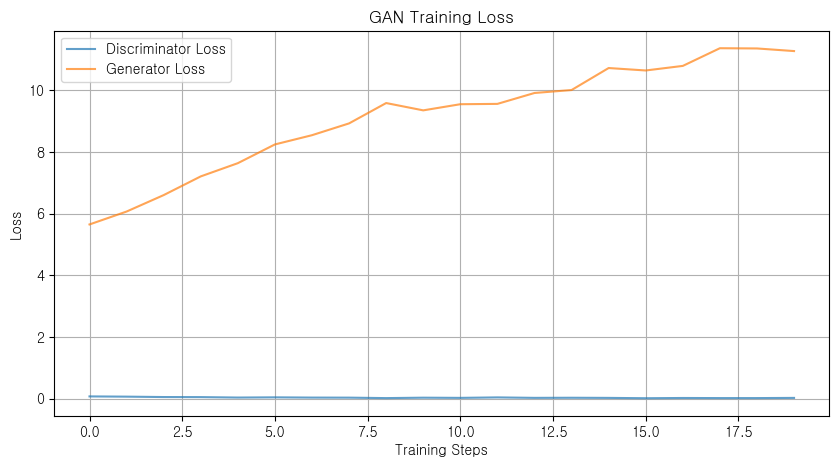

In [6]:
# 함수 호출
plot_training_history(history)

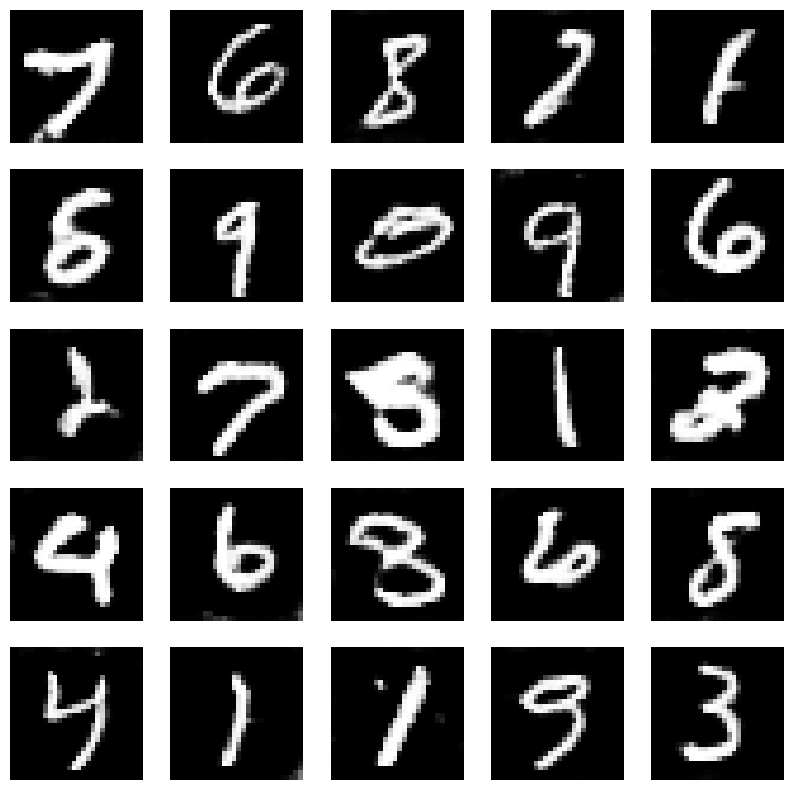

In [8]:
def plot_generator(history, num_epoch):
    gen_imgs = history['generator_images'][num_epoch]  # [25, C, H, W] 형태

    fig, ax = plt.subplots(5, 5, figsize=(10, 10))
    count = 0
    for row in range(5):
        for col in range(5):
            img = gen_imgs[count].transpose(1, 2, 0)
            if gen_imgs[-1] == 1:
                ax[row, col].imshow(img, cmap= 'gray')
            else:
                ax[row, col].imshow(img)

            ax[row, col].axis('off')
            count += 1

    plt.show()

# 첫 번째 에포크에서 생성된 이미지 가져오기
gen_imgs = history['generator_images'][19]  # [25, C, H, W] 형태

fig, ax = plt.subplots(5, 5, figsize=(10, 10))
count = 0
for row in range(5):
    for col in range(5):
        img = gen_imgs[count].transpose(1, 2, 0)
        ax[row, col].imshow(img, cmap= 'gray')
        ax[row, col].axis('off')
        count += 1

plt.show()